In [497]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# a way to hide the little red error warnings that show up sometimes: (https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)    
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


### set up paths

In [498]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [499]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

bind [127.0.0.1]:27020: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 27020
Could not request local forwarding.


In [536]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num6_shape3']

# which iteration name(s) should we use?
iterationNames = ['pilot1'] # possibilities: 'sandbox1', 'pilot1', 'sandbox2'
# this has previously been run1, then sandbox3, but switched to sandbox 3 for testing the url recording function

## Notes to Self:
# # If you ever want to see how many unique levels there are in mongodb coll
# w = coll.find({'iterationName':iterationName, 'eventType':'survey'})
# W = pd.DataFrame(w)
# coll.distinct('eventType')

list(coll.find({'iterationName':'pilot1'}).distinct("gameid"))



['9188-ec672f20-1319-40b9-8dd3-3c0bd47dc225',
 '7538-a73d2fd1-5f29-40b7-af8d-4fb1ef0f3156',
 '0755-fe65714f-db7d-44f0-af31-ea51cba4cc29',
 '1910-cceac73f-1e7e-4a92-8d62-e201c0c2d321',
 '5991-d22c9cb0-e2ec-4d0d-a945-0110dec7b27c',
 '5222-7043b375-13ca-4827-81cc-a1cb7e406fca']

In [537]:
## here is what one of these records looks like
# coll.find_one()
coll.find_one({'eventType':'clickedObj'})
# np.save(os.path.join(datastructures_dir,"workers_list.npy"),coll.distinct( "workerId" ))

{'_id': ObjectId('60d4f39bc069ba337af16a66'),
 'iterationName': 'sandbox1',
 'gameid': '1478-65da9683-649d-45d6-98b5-7cd1d14ada9b',
 'time': 1624568731751.0,
 'trialNum': 1,
 'workerId': 'A9AHPCS83TFFE',
 'assignmentId': '3TOK3KHVJXIBSVK1VY6NTOT8X6FO75',
 'object1Name': 'owl_3',
 'object1SketcherLoc': 6,
 'object1ViewerLoc': 4,
 'object2Name': 'owl_1',
 'object2SketcherLoc': 1,
 'object2ViewerLoc': 3,
 'object3Name': 'owl_2',
 'object3SketcherLoc': 2,
 'object3ViewerLoc': 2,
 'object4Name': 'owl_4',
 'object4SketcherLoc': 3,
 'object4ViewerLoc': 1,
 'intendedName': 'owl_5',
 'clickedName': 'owl_3',
 'correct': False,
 'pngString': 'iVBORw0KGgoAAAANSUhEUgAAAlgAAAJYCAYAAAC+ZpjcAAAgAElEQVR4Xu3dCdh261g38H+GD0n4DIX4REo4IqF2IcRHyJAMFSpKiLRJpHmgSDtTlKhMZSwOQz5lzlCh2NgSylDGDClT1Hdce9/v7t3bft/7Wus57/tZw28dx3M8W8+5znVdv+va+/l33+tZ95fEQYAAAQIECBAgUCrwJaXdNCNAgAABAgQIEIiAZRMQIECAAAECBIoFBKxiUO0IECBAgAABAgKWPUCAAAECBAgQKBYQsIpBtSNAgAABAgQICFj2AAECBAgQIECgWEDAKgbVjgABAgQIECAgYNkDBAgQIECAAIFiAQGrGFQ7

### Initialize dataframes

In [538]:
## fetch records that match our list of iterationNames
print('Currently trying to generate clickedObj group dataframe...')
k = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'clickedObj'})
## create (raw, unfiltered) group dataframe containing all clickedObj 
## data from iterationNames of interest
K = pd.DataFrame(list(k))
K = K.astype({'time': 'int'})
print('Finished generating clickedObj group dataframe.')

## now make group dataframe for stroke data
print('Currently trying to generate stroke group dataframe...')
t = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'stroke'})
T = pd.DataFrame(list(t))
T = T.astype({'time': 'int',
              'startStrokeTime': 'int',
              'endStrokeTime': 'int',
              'currStrokeNum':'int'})
print('Finished generating stroke group dataframe.')

## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==30] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

# save out to csv
T.to_csv(os.path.join(csv_dir,'photodraw_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'photodraw_sketch_data.csv'),index=False)
print('Successfully saved out our stroke/sketch data CSVs to {}.'.format(csv_dir))

# changing the target url because I want it in the sketch metadata, but '/' gets read as file path, so just take suffix
for i in K.index:
    K['targ_s_url'][i] = K['targ_s_url'][i].split('/')[-1]

## generate group dataframe and save out to file
# importlib.reload(utils)



Currently trying to generate clickedObj group dataframe...
Finished generating clickedObj group dataframe.
Currently trying to generate stroke group dataframe...
Finished generating stroke group dataframe.
We have 1623 unique stroke records in all 4 of our complete games.
We have 120 unique sketch records in all 4 of our complete games.
Successfully saved out our stroke/sketch data CSVs to /Users/alles/repos/iterated_number/results/csv.


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [539]:
print('Now crunching some numbers and adding more useful columns to the raw dataframe...')
D = utils.generate_dataframe(coll, complete_gameids, iterationName, csv_dir)
print('Done processing group dataframe with lots of handy additional columns!')

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

## some additional postprocessing: add arc length information to the group dataframe 
try:
    from bezier import curve
    from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path
    D = utils.GetArcLenData(D)
except:
    print('Something went wrong with adding arc length info to the dataframe, sorry!')
    pass

# Keep track of which quarter of the experiment the trial happened in
D['quarter'] = np.ceil(D['trialNum']/8)
D = D.astype({'quarter': 'float'})
D['cardinality'] = D['cardinality'] + 1 #cardinalities are 0-indexed, which is ugly

D_backup = D #we are going to exclude data from D, so might as well back it up into another variable too

Done!
Done processing group dataframe with lots of handy additional columns!
Something went wrong with adding arc length info to the dataframe, sorry!


In [540]:
## monitor how far along games-in-progress are
all_games = K['gameid'].unique()
num_games = len(all_games)
print('There are a total of {} unique gameids in mongo.'.format(num_games))

print('\n')
print('These are the games and how many trials have been completed so far:')
for name, group in K.groupby('gameid'):
    print('gameid: {} | number of trials : {}'.format(name, group.shape[0]))

There are a total of 4 unique gameids in mongo.


These are the games and how many trials have been completed so far:
gameid: 0755-fe65714f-db7d-44f0-af31-ea51cba4cc29 | number of trials : 30
gameid: 1910-cceac73f-1e7e-4a92-8d62-e201c0c2d321 | number of trials : 30
gameid: 5991-d22c9cb0-e2ec-4d0d-a945-0110dec7b27c | number of trials : 30
gameid: 7538-a73d2fd1-5f29-40b7-af8d-4fb1ef0f3156 | number of trials : 30


In [541]:
## TODO: hash 'workerId' so that we do not save actual workerIDs to file.


### Cleaning (this code was *after* image rendering to sort out the duds. Now it has been moved to *before* image rendering so that we only generate the images that we want to analyze in the NN)

In [542]:
# Get the data out onto a CSV so we can do some analysis in R

# First clean it up by removing games that we have to exclude. Get dud games manually:
dud_games = []
# now remove them from both D and K
for dud in dud_games:
    D = D[D.gameID != dud]
    K = K[K.gameid != dud]

# the names of the games we want to keep:
kosher_games = [game for game in complete_gameids if game not in dud_games]

# Export the csv. This is what the R script will look at
D.to_csv(os.path.join(csv_dir,'iternum_group_data_{}.csv'.format(iterationName)))


In [543]:
D = pd.read_csv(os.path.join(csv_dir,'iternum_group_data_{}.csv'.format(iterationName)))


### render out all the sketches

In [544]:
importlib.reload(utils)
utils.render_images(K,data = 'pngString',
                    metadata = ['gameid','intendedName','trialNum','game_condition','targ_s_url'],
                    out_dir = sketch_dir,
                    delimiter = '_', # used to be '_', but changed because want url in metadata and url has '_'
                    savetargs = False)
#                     NN=True) # why did I write this? Might be a version control mistake here somewhere...

Done rendering 120 images to /Users/alles/repos/iterated_number/sketches.


### make sketch gallery (for complete games only)

In [545]:
importlib.reload(utils)
## actually render sketch gallery for each complete game
utils.render_sketch_gallery(complete_gameids,
                            D,
                            sketch_dir = sketch_dir,
                            gallery_dir = gallery_dir,
                            num_trials = 30,
                            by_trialnum = True,
                            show_correct = True,
                            transpose=False,
                            delimiter='_')

Generating sketch gallery for participant: 7538-a73d2fd1-5f29-40b7-af8d-4fb1ef0f3156 | 1 of 4
Generating sketch gallery for participant: 0755-fe65714f-db7d-44f0-af31-ea51cba4cc29 | 2 of 4
Generating sketch gallery for participant: 1910-cceac73f-1e7e-4a92-8d62-e201c0c2d321 | 3 of 4
Generating sketch gallery for participant: 5991-d22c9cb0-e2ec-4d0d-a945-0110dec7b27c | 4 of 4
Done!


### show sketch galleries with target stimulus below

In [557]:
# Looking visually to see if the spatial distributions of sketcher target matches the sketches
def show_targ_and_sketch(ID,trialnum,disp=True):
    """
    Just a function that plots a sketch (specified by the gameID and trial number) with its target stimulus.
    Output of this function is the image showing both side by side.
    """
    game = D[D.gameID == ID]
    trial = game[game.trialNum == trialnum]
    stim_url = trial['Targ_s_Url'].values[0]
    get_stim = requests.get(stim_url)
    stim = Image.open(BytesIO(get_stim.content))
    
    get_sketch = trial['png'].values[0]
    sketch = Image.open(BytesIO(base64.b64decode(get_sketch)))
    
    sketch = sketch.resize((100,100))
    stim = stim.resize((100,100))
    
    images = [sketch,stim]
    widths, heights = zip(*(i.size for i in images))
    total_width = max(widths)
    max_height = sum(heights)
    whole_trial = Image.new('RGBA', (total_width, max_height),color='white')
    y_offset = 0
    for im in images:
        whole_trial.paste(im, (0,y_offset))
        y_offset += im.size[1]
    if disp == True:
        display(whole_trial)
    return whole_trial

def show_targs_sketches_game(ID,save=False):
    """
    This function takes in a gameID and shows sketches and their targets for every trial, side by side.
    Optionally, it will save this output into a png.
    """
    whole_game = Image.new('RGBA', (3200, 200),color='white')
    for trial_num in np.arange(1,33):
        trial = show_targ_and_sketch(ID,trial_num,disp=False)
        whole_game.paste(trial,(trial_num*100-100,0))
        
    if save == True:
        condition = D[D.gameID == ID]['Game_Condition'].values[0]
        fname = str(condition) + '_' + ID + "_s_s"
        
        out_dir = './sketches_stims'
        # create the out_dir if it does not already exist
        if not os.path.exists(out_dir): 
            os.makedirs(out_dir)
            
        # now save the image out to that directory
        if not os.path.exists(os.path.join(out_dir,fname+'.png')):
            print('Rendering…', fname + '.png') 
            whole_game.save(os.path.join(out_dir,fname+'.png'),'PNG')
            
    return whole_game

# for game_id in kosher_games:
#     print("Now generating sketch + stim display for ",game_id)
#     show_targs_sketches_game(game_id,save=True)


## Analysis things

In [547]:
def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std'] """
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    return new_df


# (a) qualitative sketch data
# (b) accuracy
# (c) preparatory time and sketch time
# (d) ink use distribution
# (e) all variables over time


### Accuracy

Text(0.5, 1.0, 'Accuracy over Trials')

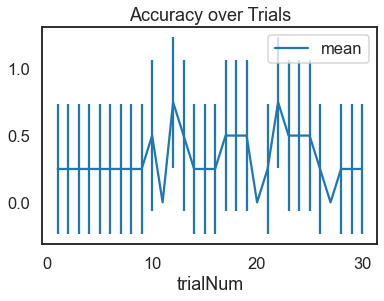

In [558]:
# plot the average accuracy over time
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Accuracy over Trials")

### Time

Text(0.5, 1.0, 'Draw Duration (measure 2)')

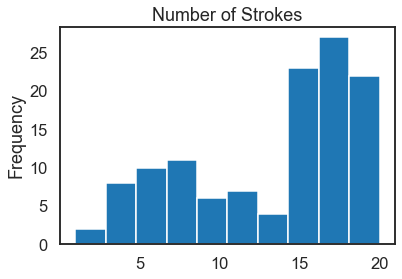

<Figure size 432x288 with 0 Axes>

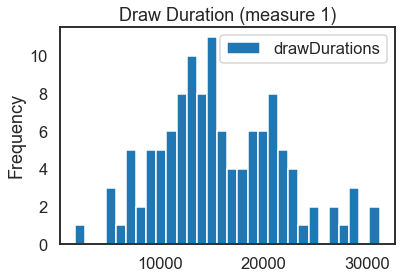

<Figure size 432x288 with 0 Axes>

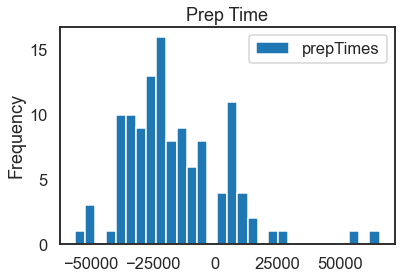

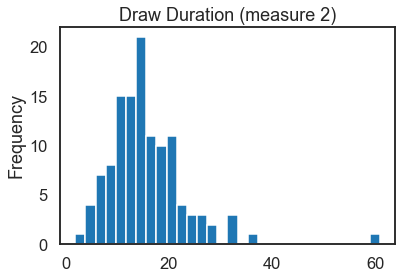

In [556]:
lastStrokeDF = pd.DataFrame(T.groupby(['gameid','trialNum'])['currStrokeNum'].max())
lastStrokeDF = lastStrokeDF.rename(columns={"currStrokeNum": "lastStroke"})
lastStrokeDF = lastStrokeDF.astype({'lastStroke': 'int'})

if 'lastStroke' not in T.columns:
    T = T.join(lastStrokeDF, how='left', on=['gameid','trialNum'])

lastStrokeDF['lastStroke'].plot.hist()
plt.title("Number of Strokes")

# for each trial (except the first), we reconstruct the time scale as follows:
# clickedTimes: viewer submit time from last trial (cues stim presentation of trial)
# penDownTimes: first 'pen down', the first stroke startStrokeTime
# penUpTimes: time when sketcher finished making the last stroke

clickedTimes = K['time'].reset_index(drop=True) 
strokeTimes = T[T['currStrokeNum'] == 1]['time'].reset_index(drop=True) 
penDownTimes = T[T['currStrokeNum'] == 1]['startStrokeTime'].reset_index(drop=True)
penUpTimes = T[T['currStrokeNum'] == T['lastStroke']]['endStrokeTime'].reset_index(drop=True)

if 'trialStartTime' in T.columns:
    trialStartTimes = T[T['currStrokeNum'] == 1]['trialStartTime'].reset_index(drop=True) 
    timing = pd.DataFrame({'Start': trialStartTimes, 'PenDown': penDownTimes, 'PenUp': penUpTimes})
    timing['prepTime'] = timing.PenDown - timing.Start
    timing['drawTime'] = timing.PenUp - timing.PenDown
    timing['totalTime'] = timing.PenUp - timing.Start
else:
    strokeTimes = strokeTimes.drop([0])
    penDownTimes = penDownTimes.drop([0])
    penUpTimes = penUpTimes.drop([0])
    clickedTimes = clickedTimes.drop([len(clickedTimes)-1])
    clickedTimes.index = range(1,len(clickedTimes)+1)

plt.figure()
pd.DataFrame(penUpTimes - penDownTimes,columns=['drawDurations']).plot.hist(bins=30)
plt.title("Draw Duration (measure 1)")

plt.figure()
pd.DataFrame(penDownTimes - clickedTimes,columns=['prepTimes']).plot.hist(bins=30)
plt.title("Prep Time")


plt.figure()
D['drawDuration'].plot.hist(bins=30)
plt.title("Draw Duration (measure 2)")



In [550]:
np.mean(penUpTimes - penDownTimes)

15826.268907563026

In [551]:

# is the 'time' from K informationally identical to the 'trialStartTime' from T? Testing on dataframes where we measure both
if 'trialStartTime' in T.columns:
    clickedTimes[:-1].reset_index(drop=True) - T[T['currStrokeNum'] == 1].trialStartTime.reset_index(drop=True)[1:].reset_index(drop=True)


Text(0.5, 1.0, 'Draw Duration over Trials')

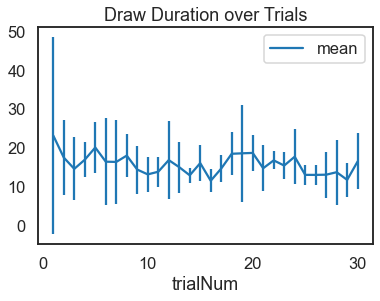

In [567]:
# plot the time spent drawing for each trial on average
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Draw Duration over Trials")

### Ink Used

array([[<AxesSubplot:title={'center':'meanPixelIntensity'}>]],
      dtype=object)

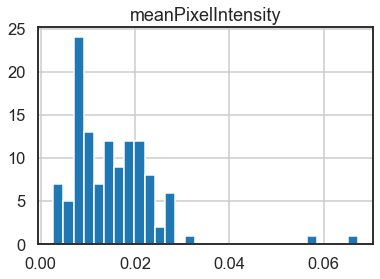

In [553]:
# plot the amount of ink used in each sketch
D[['meanPixelIntensity']].hist(bins=30)

### Other things over trials

Text(0.5, 1.0, 'NumStrokes over Trials')

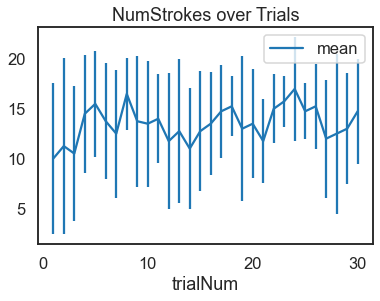

In [560]:
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['numStrokes'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("NumStrokes over Trials")

Text(0.5, 1.0, 'Ink over Trials')

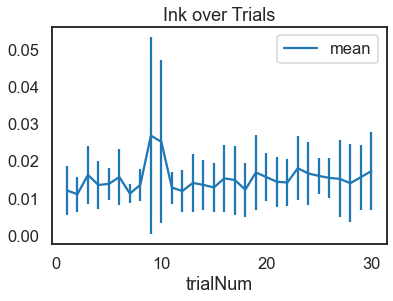

In [566]:
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['meanPixelIntensity'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Ink over Trials")

Text(0.5, 1.0, 'Accuracy over Cardinality')

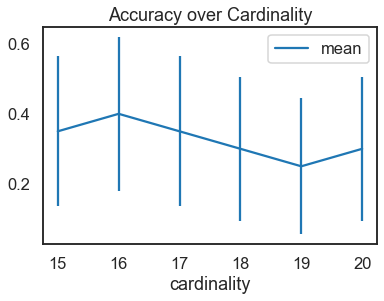

In [572]:
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Accuracy over Cardinality")

Text(0.5, 1.0, 'Draw Duration over Cardinality')

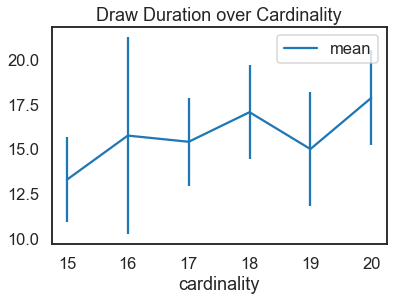

In [570]:
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Draw Duration over Cardinality")

In [589]:
D['guess_cardinality'] = D.response.str.slice(start=-2)
D = D.astype({'guess_cardinality': 'int'})

D['targ_cardinality'] = D.target.str.slice(start=-2)
D = D.astype({'targ_cardinality': 'int'})


D['distance'] = D.guess_cardinality - D.targ_cardinality


<AxesSubplot:xlabel='guess_cardinality', ylabel='targ_cardinality'>

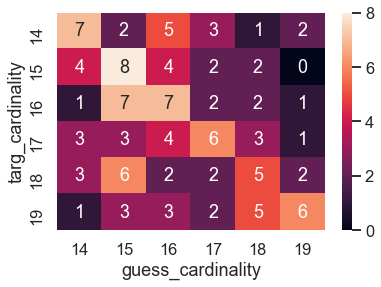

In [594]:
plt.pcolor(D[['targ_cardinality','guess_cardinality']])

confmat = pd.crosstab(D['targ_cardinality'], D['guess_cardinality'])

sns.heatmap(confmat, annot=True)
